# The goal of this project is to create a CNN that can classify images into one of 10 classes:
- airplane,
- automobile,
- bird,
- cat,
- deer,
- dog,
- frog,
- horse,
- ship, and
- truck.

# The CIFAR-10 dataset is a popular benchmark in the field of computer vision.

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from matplotlib.patches import Circle

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from itertools import cycle


from sklearn.metrics import roc_curve, auc
from matplotlib import cm
import cv2
from sklearn.model_selection import train_test_split
from keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import load_model
%matplotlib inline

2024-05-23 06:52:36.094594: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-23 06:52:36.094712: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-23 06:52:36.229763: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0


In [3]:
# Downloading the CIFAR-10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [4]:
# split the dataset in train and validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [5]:
# printing the shape of training, validation and test data
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)


x_train shape: (40000, 32, 32, 3)
y_train shape: (40000, 1)
x_val shape: (10000, 32, 32, 3)
y_val shape: (10000, 1)


In [6]:
# CIFAR-10  classes as a list
label_name = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

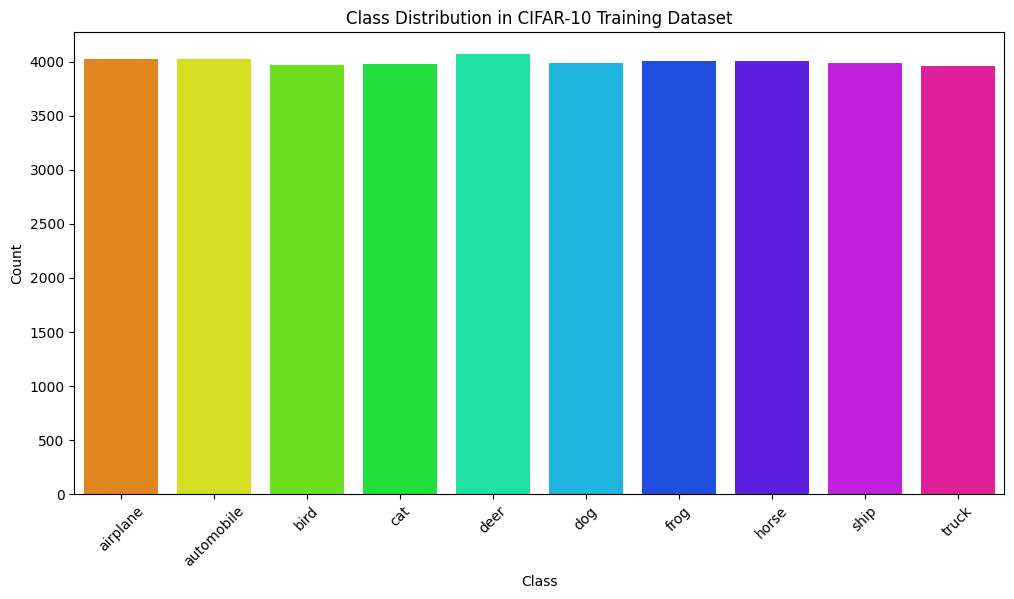

In [7]:
unique, counts = np.unique(y_train, return_counts=True)
class_counts = dict(zip(label_name, counts))

class_counts_df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])

plt.figure(figsize=(12, 6))
sns.barplot(x='Class', y='Count', data=class_counts_df, palette='hsv')
plt.title('Class Distribution in CIFAR-10 Training Dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [8]:
class_counts_df 

,Class,Count
0,airplane,4027
1,automobile,4021
2,bird,3970
3,cat,3977
4,deer,4067
5,dog,3985
6,frog,4004
7,horse,4006
8,ship,3983
9,truck,3960


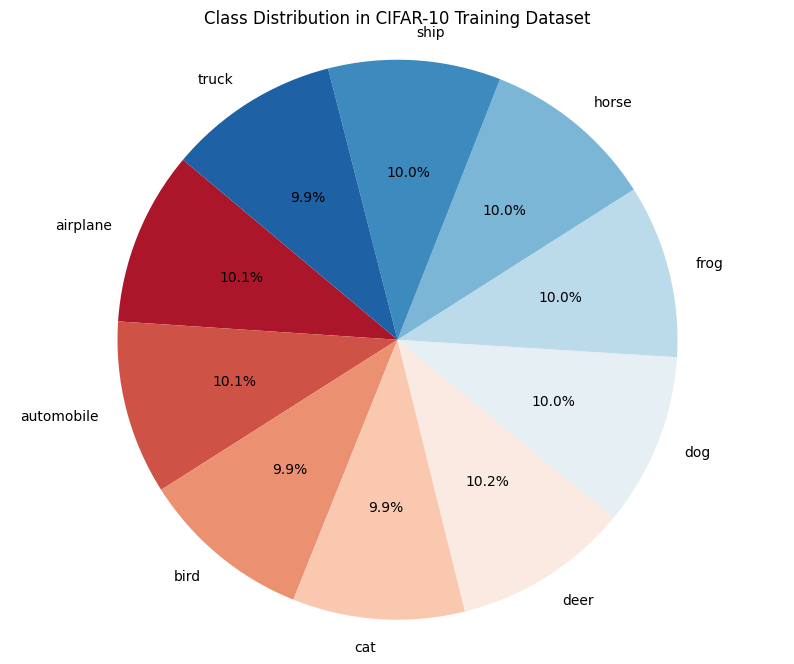

In [9]:
unique, counts = np.unique(y_train, return_counts=True)
class_counts = dict(zip(label_name, counts))

class_counts_df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])

plt.figure(figsize=(10, 8))
plt.pie(class_counts_df['Count'], labels=class_counts_df['Class'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('RdBu', len(label_name)))
plt.title('Class Distribution in CIFAR-10 Training Dataset')
plt.axis('equal')
plt.show()

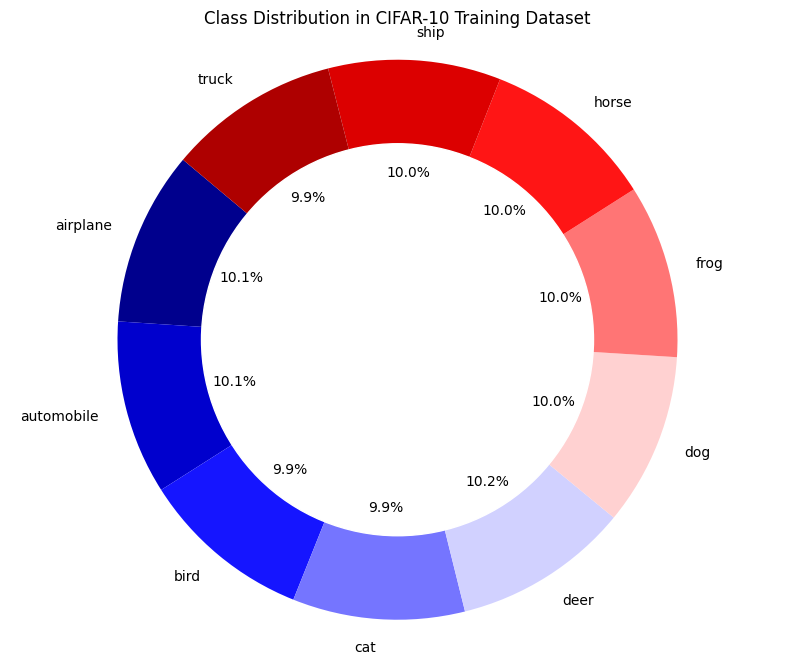

In [10]:
unique, counts = np.unique(y_train, return_counts=True)
class_counts = dict(zip(label_name, counts))

class_counts_df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])

plt.figure(figsize=(10, 8))

wedges, texts, autotexts = plt.pie(class_counts_df['Count'], labels=class_counts_df['Class'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('seismic', len(label_name)))

circle = Circle((0, 0), 0.7, color='white')
plt.gca().add_artist(circle)

plt.axis('equal')
plt.title('Class Distribution in CIFAR-10 Training Dataset')

plt.show()






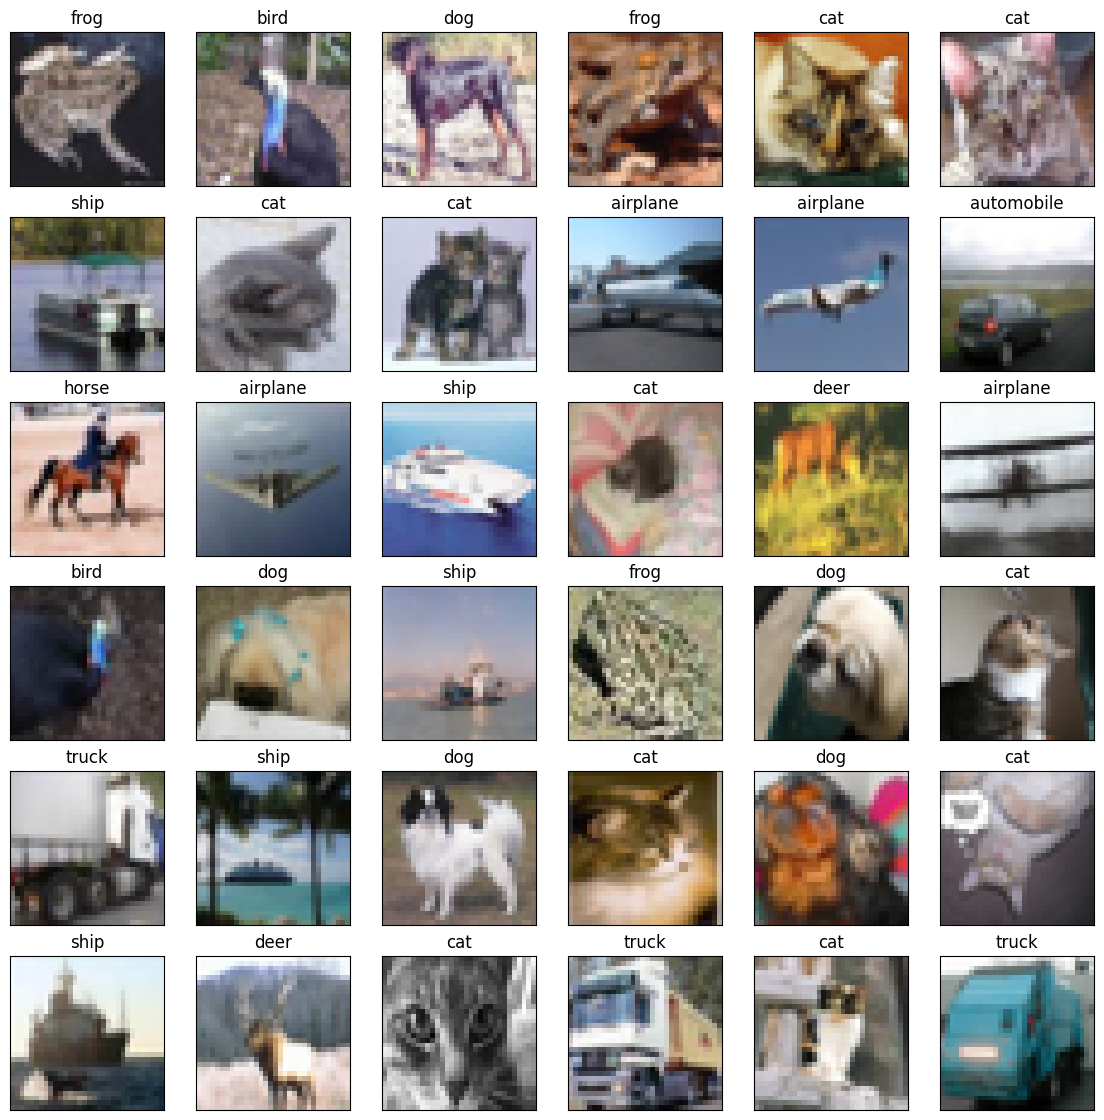

In [11]:
# let's see the first 25 images from our cifar-10 dataset

plt.figure(figsize=(14,14))
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.title(label_name[y_train[i][0]])
plt.show()

# Data Preprocessing

- Normalization
- Encoding
- Data Augmentation

In [12]:
# pixel values to float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_val = x_val.astype('float32')

In [13]:
mean = np.mean(x_train)
std = np.std(x_train)

print(mean)
print(std)

120.73008
64.074066


In [14]:
x_train = (x_train - mean) / (std+1e-7)
x_test = (x_test - mean) / (std+1e-7)
x_val = (x_val - mean) / (std+1e-7)

In [15]:
# converting the class labels into one-hot vectors
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
y_val = to_categorical(y_val, 10)

In [16]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.3,
    brightness_range=[0.8,1.2],
    channel_shift_range=0.2
)

In [17]:
x_train.shape[1:]

(32, 32, 3)

# Create ZFNet Model

In [18]:
from tensorflow.keras import layers, models
model = Sequential()

# First layer (ZFNet used 7x7 filters)
model.add(layers.Conv2D(96, (7, 7), strides=(2, 2), padding='same', activation='relu', input_shape=x_train.shape[1:]))
model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Second layer
model.add(layers.Conv2D(256, (5, 5), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Third layer
model.add(layers.Conv2D(384, (3, 3), padding='same', activation='relu'))

# Fourth layer
model.add(layers.Conv2D(384, (3, 3), padding='same', activation='relu'))

# Fifth layer
model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Flatten
model.add(layers.Flatten())

# Fully connected layers
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 16, 16, 96)     │        14,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 7, 7, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 256)      │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 384)      │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 3, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 3, 3, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        40,970 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,601,418 (82.40 MB)

 Trainable params: 21,601,418 (82.40 MB)

 Non-trainable params: 0 (0.00 B)

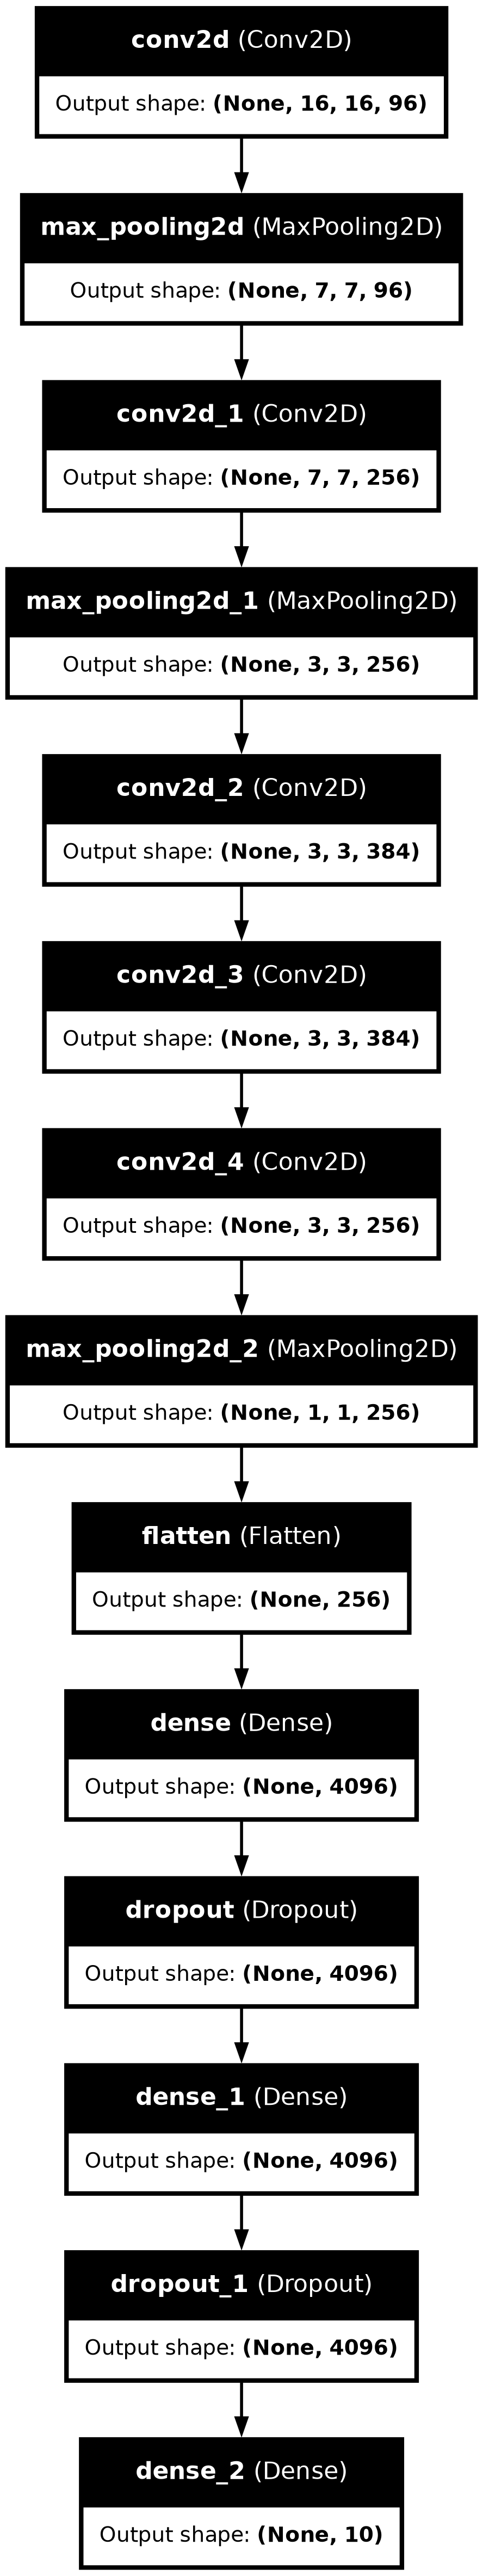

In [41]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='zfnet_cifar10.png', show_shapes=True, show_layer_names=True)


In [19]:
batch_size =64
epochs = 100



reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 5, min_lr = 0.00001)
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 10, verbose = 1, mode = 'auto')

model.fit(x_train, y_train, batch_size = batch_size,
          epochs = epochs,
          validation_data = (x_val, y_val),
          callbacks = [reduce_lr, early_stop],
          verbose = 1)

Epoch 1/100
 15/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.1034 - loss: 2.3012 

I0000 00:00:1716447187.423526     157 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716447187.441835     157 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2897 - loss: 1.8732

W0000 00:00:1716447195.136756     159 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.2898 - loss: 1.8728 - val_accuracy: 0.5206 - val_loss: 1.3152 - learning_rate: 1.0000e-04
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.5393 - loss: 1.2634 - val_accuracy: 0.5874 - val_loss: 1.1365 - learning_rate: 1.0000e-04
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6247 - loss: 1.0468 - val_accuracy: 0.6451 - val_loss: 1.0119 - learning_rate: 1.0000e-04
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6863 - loss: 0.8828 - val_accuracy: 0.6648 - val_loss: 0.9211 - learning_rate: 1.0000e-04
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7332 - loss: 0.7462 - val_accuracy: 0.6980 - val_loss: 0.8668 - learning_rate: 1.0000e-04
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7854 - loss: 0.6195 - val_accuracy: 0.7153 - val_loss: 0.8450 - learning_rate: 1.0000e-04
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accurac

In [20]:
model.save('trained_model_10.h5')

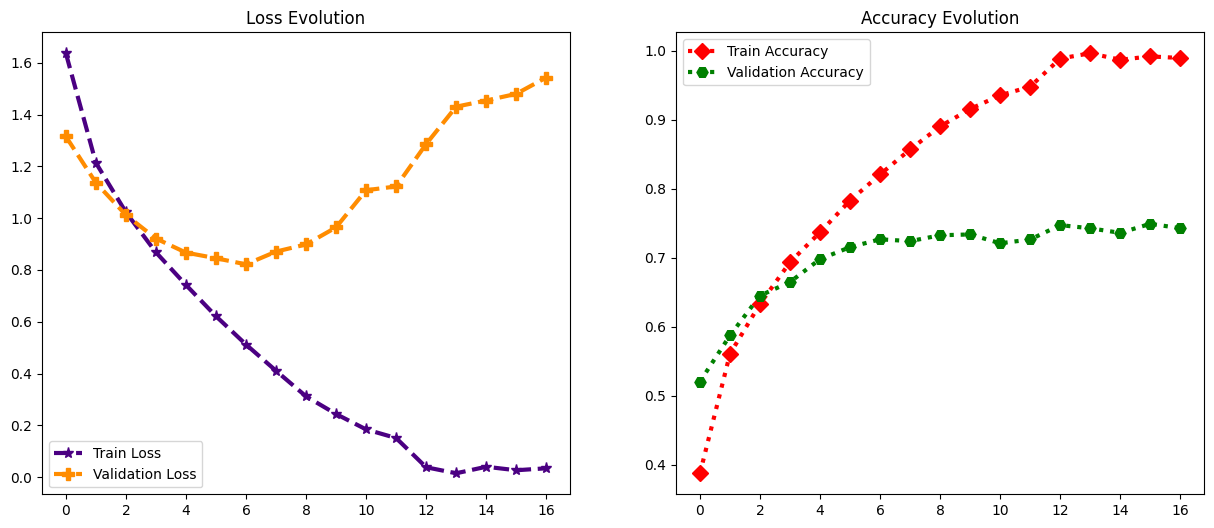

In [21]:
plt.figure(figsize=(15,6))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(model.history.history['loss'], label='Train Loss', color='indigo',marker="*",lw=3,markersize=8,linestyle="--")
plt.plot(model.history.history['val_loss'], label='Validation Loss', color='darkorange',marker="P",lw=3,markersize=8,linestyle="--")
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(model.history.history['accuracy'], label='Train Accuracy', color="red",marker="D",lw=3,markersize=8,linestyle=":")
plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy', color='green',marker="H",lw=3,markersize=8,linestyle=":")
plt.legend()
plt.title('Accuracy Evolution')

plt.show()

In [22]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)

print('\nTest Accuracy:', test_acc)
print('Test Loss:    ', test_loss)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7451 - loss: 1.5669

Test Accuracy: 0.7405999898910522
Test Loss:     1.611112356185913


In [23]:
pred=model.predict(x_test)
final_pred=np.argmax(pred,axis=1)
y_test_labels = np.argmax(y_test, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


# confusion matrix

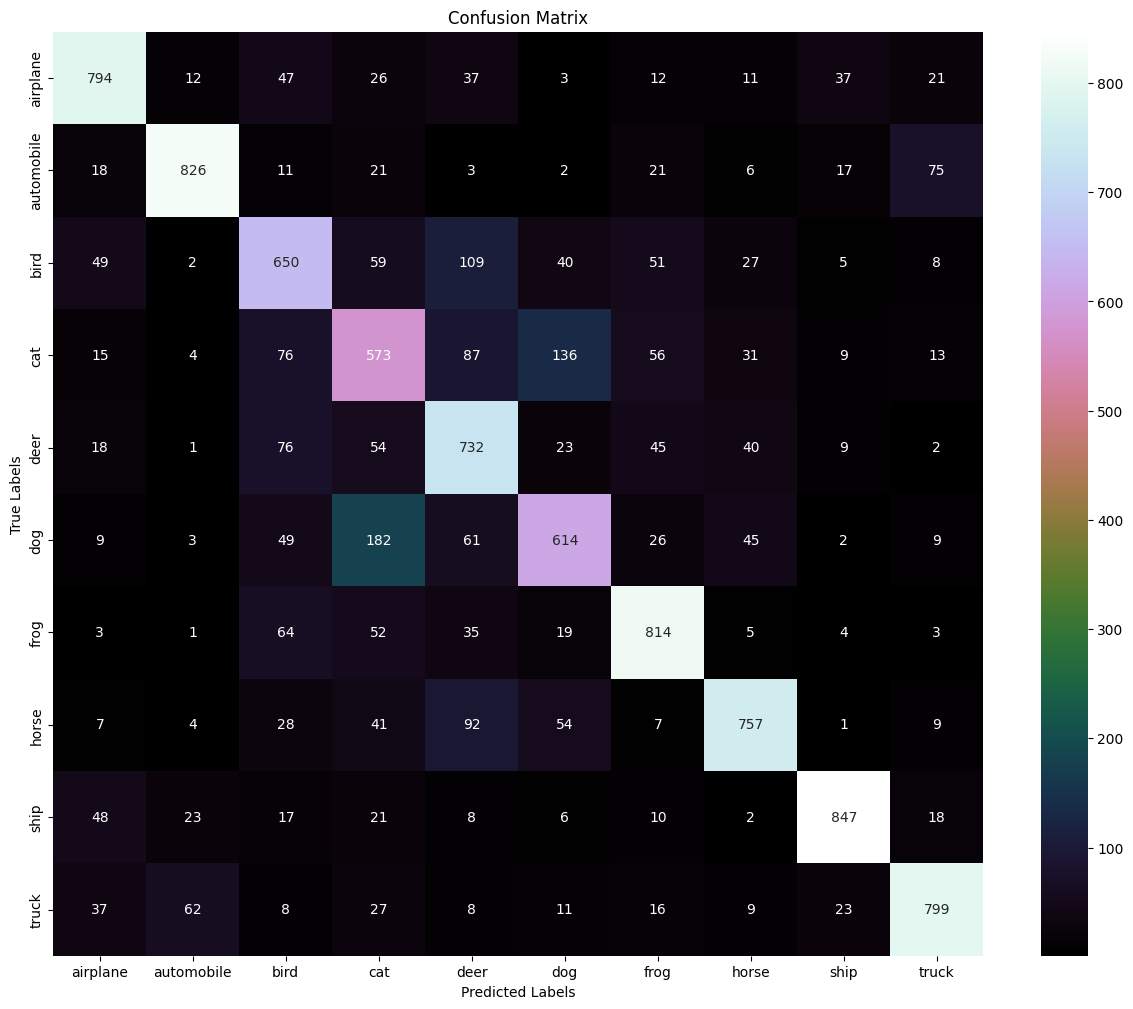

In [24]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report, log_loss,accuracy_score
import seaborn as sns
cm = confusion_matrix(y_test_labels, final_pred)
plt.figure(figsize=(15,12))
sns.heatmap(cm,annot=True,fmt="d",xticklabels=label_name,yticklabels=label_name,cmap="cubehelix")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [25]:
print(classification_report(y_test_labels,final_pred,target_names=label_name))

              precision    recall  f1-score   support

    airplane       0.80      0.79      0.79      1000
  automobile       0.88      0.83      0.85      1000
        bird       0.63      0.65      0.64      1000
         cat       0.54      0.57      0.56      1000
        deer       0.62      0.73      0.67      1000
         dog       0.68      0.61      0.64      1000
        frog       0.77      0.81      0.79      1000
       horse       0.81      0.76      0.78      1000
        ship       0.89      0.85      0.87      1000
       truck       0.83      0.80      0.82      1000

    accuracy                           0.74     10000
   macro avg       0.75      0.74      0.74     10000
weighted avg       0.75      0.74      0.74     10000



# Classification report

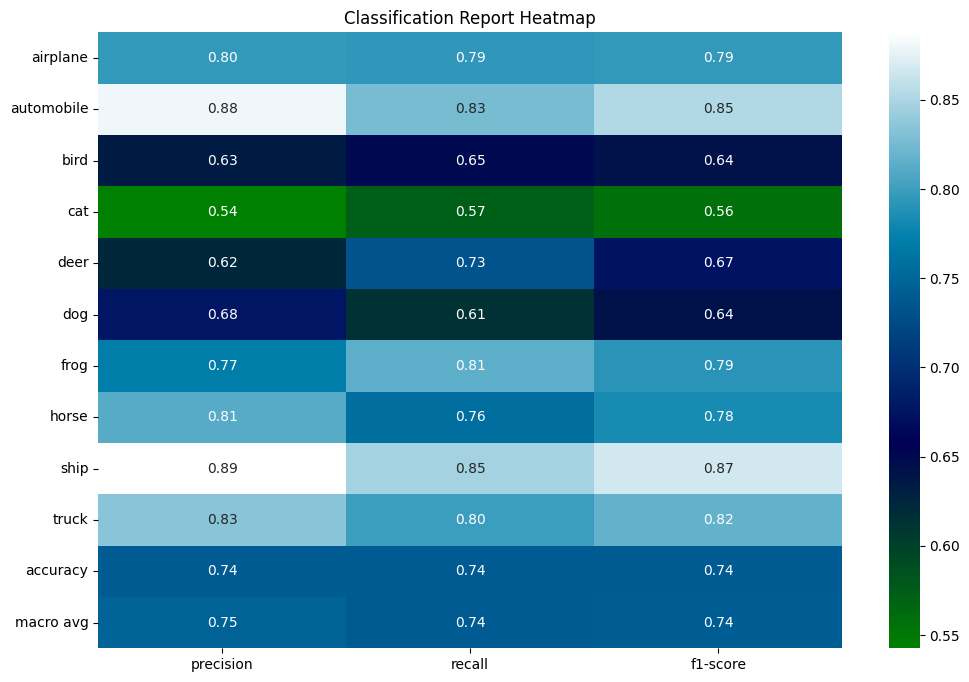

In [26]:
report = classification_report(y_test_labels, final_pred, target_names=label_name, output_dict=True)
report_df = pd.DataFrame(report).transpose()
plt.figure(figsize=(12, 8))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='ocean', fmt='.2f')
plt.title('Classification Report Heatmap')
plt.show()

# Accuracy Score

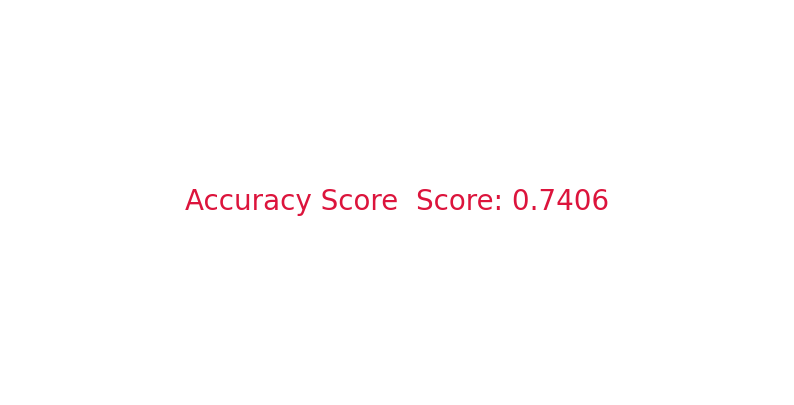

In [27]:
plt.figure(figsize=(10,5),facecolor="white")
acc_score = accuracy_score(y_test_labels,final_pred)
plt.plot([])
plt.text(0,0, f'Accuracy Score  Score: {acc_score:.4f}', fontsize=20, ha='center', va='center',color="crimson")
plt.axis('off')

# Set the x-axis limits
plt.xlim(-1, 1)
plt.ylim(-1,1)

plt.show()

# ROC AUC Score

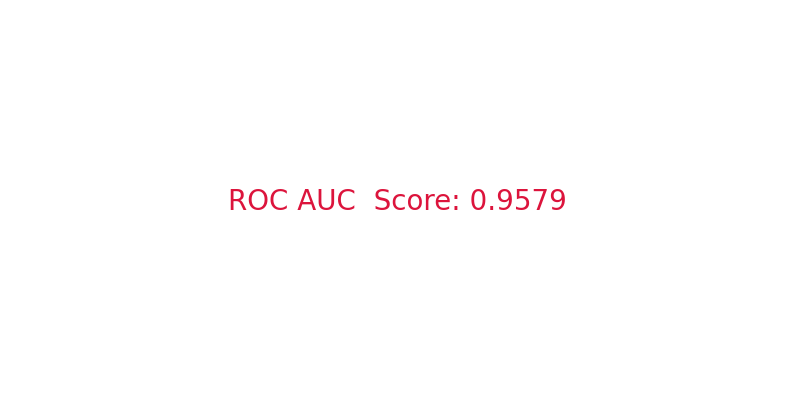

In [28]:
plt.figure(figsize=(10,5),facecolor='white')
roc_auc = roc_auc_score(y_test_labels, pred,multi_class='ovr')
plt.plot([])
plt.text(0,0, f'ROC AUC  Score: {roc_auc:.4f}', fontsize=20, ha='center', va='center',color="crimson")
plt.axis('off')

# Set the x-axis limits
plt.xlim(-1, 1)
plt.ylim(-1,1)

plt.show()

# Cohen Kappa Score

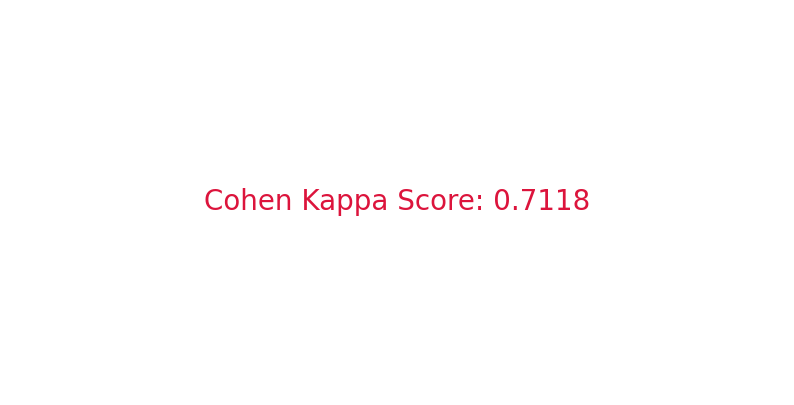

In [29]:
from sklearn.metrics import cohen_kappa_score
plt.figure(figsize=(10,5),facecolor="white")
kappa = cohen_kappa_score(y_test_labels,final_pred)
plt.plot([])
plt.text(0,0, f'Cohen Kappa Score: {kappa:.4f}', fontsize=20, ha='center', va='center',color="crimson")
plt.axis('off')

# Set the x-axis limits
plt.xlim(-1, 1)
plt.ylim(-1,1)

plt.show()

# Matthews Correlation Coefficient

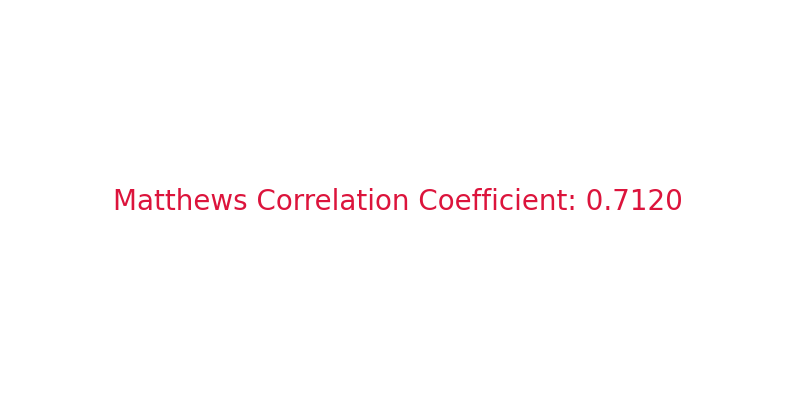

In [30]:
from sklearn.metrics import matthews_corrcoef
plt.figure(figsize=(10,5),facecolor="white")
mcc = matthews_corrcoef(y_test_labels, final_pred)

# Create a plot and display the MCC value as text
plt.plot([])
plt.text(0,0, f'Matthews Correlation Coefficient: {mcc:.4f}', fontsize=20, ha='center', va='center',color="crimson")
plt.axis('off')

# Set the x-axis limits
plt.xlim(-1, 1)
plt.ylim(-1,1)

plt.show()

# Brier Score Loss _1

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


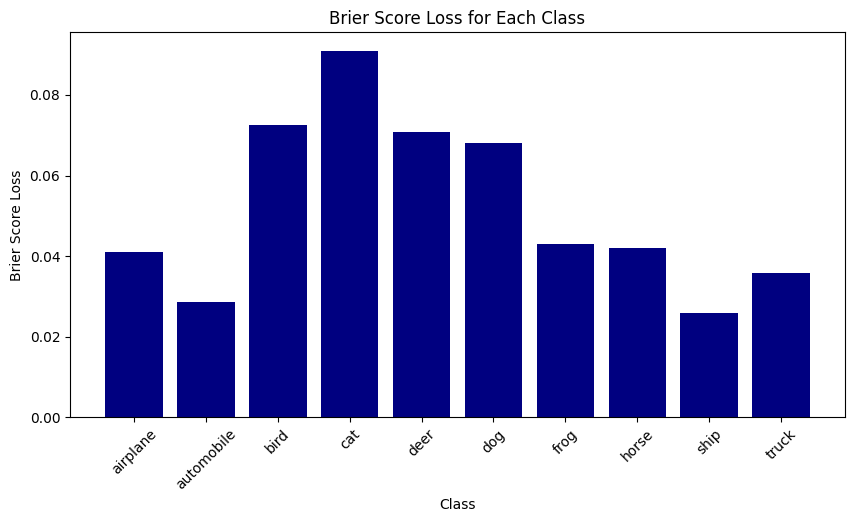

In [31]:
import pandas as pd
from sklearn.metrics import brier_score_loss


pred = model.predict(x_test)
final_pred = np.argmax(pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

num_classes = len(label_name)  # Number of classes

brier_scores = []
for class_label in range(num_classes):
    class_mask = (y_test_labels == class_label)
    class_pred = (final_pred == class_label)
    brier_score = brier_score_loss(class_mask, class_pred)
    brier_scores.append(brier_score)

df = pd.DataFrame({'Class': label_name, 'Brier Score Loss': brier_scores})
plt.figure(figsize=(10, 5), facecolor="white")
plt.bar(df['Class'], df['Brier Score Loss'], color='navy')
plt.xlabel('Class')
plt.ylabel('Brier Score Loss')
plt.title('Brier Score Loss for Each Class')
plt.xticks(rotation=45)
plt.show()


In [32]:
df

,Class,Brier Score Loss
0,airplane,0.0410
1,automobile,0.0286
2,bird,0.0726
3,cat,0.0910
4,deer,0.0708
5,dog,0.0680
6,frog,0.0430
7,horse,0.0419
8,ship,0.0260
9,truck,0.0359


# Brier Score Loss

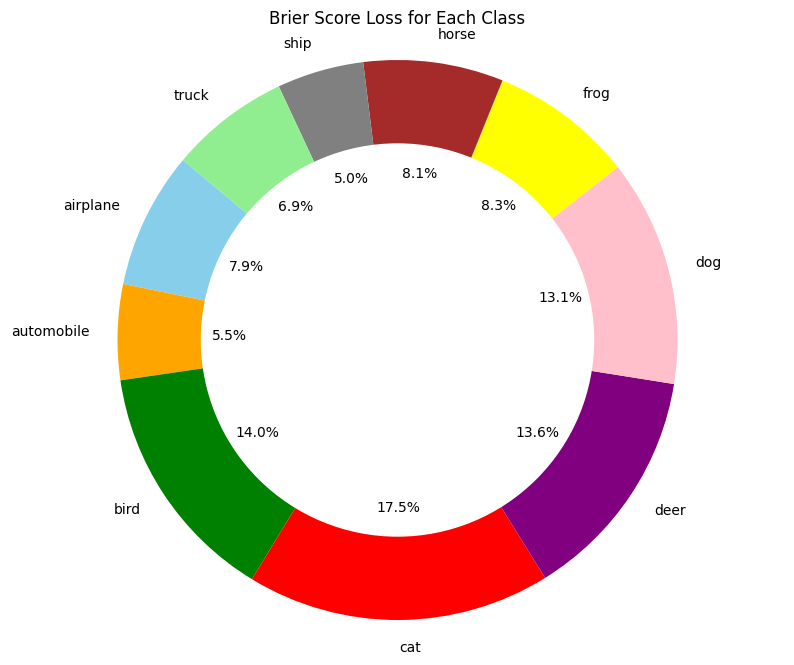

In [33]:


colors = ['skyblue', 'orange', 'green', 'red', 'purple', 'pink', 'yellow', 'brown', 'grey', 'lightgreen']

plt.figure(figsize=(10, 8))
ax = plt.gca()

wedges, texts, autotexts = ax.pie(df['Brier Score Loss'], labels=df['Class'], autopct='%1.1f%%', startangle=140, colors=colors)

circle = Circle((0, 0), 0.7, color='white')
ax.add_artist(circle)

ax.axis('equal')
plt.title('Brier Score Loss for Each Class')
plt.show()


# Precision,Recall Score

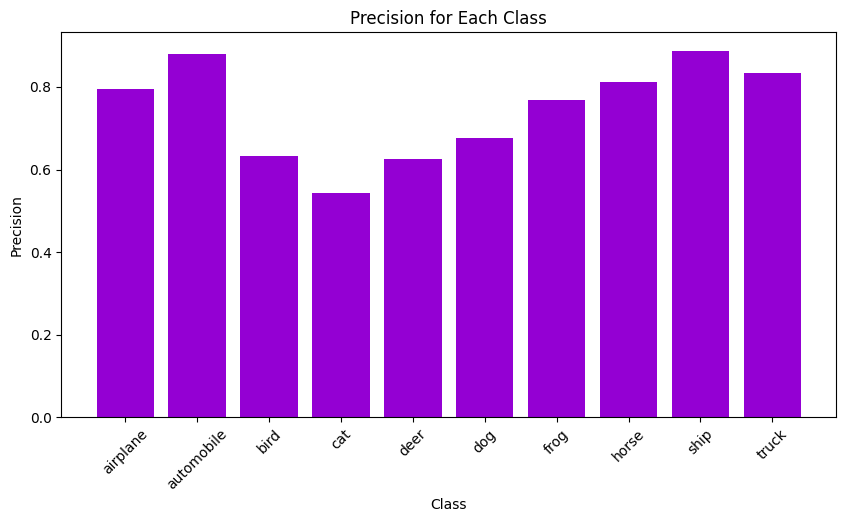

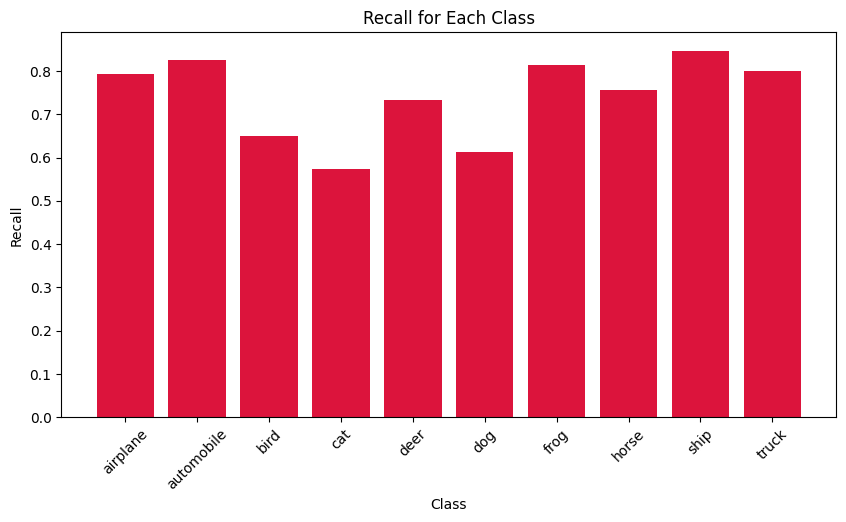

In [34]:

from sklearn.metrics import precision_score, recall_score



precisions = []
recalls = []

for class_label in range(num_classes):
    class_mask = (y_test_labels == class_label)
    class_pred = (final_pred == class_label)
    
    precision = precision_score(class_mask, class_pred)
    recall = recall_score(class_mask, class_pred)
    
    precisions.append(precision)
    recalls.append(recall)

df = pd.DataFrame({'Class': label_name, 'Precision': precisions, 'Recall': recalls})

# Plotting precision
plt.figure(figsize=(10, 5), facecolor="white")
plt.bar(df['Class'], df['Precision'], color='darkviolet')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Precision for Each Class')
plt.xticks(rotation=45)
plt.show()

# Plotting recall
plt.figure(figsize=(10, 5), facecolor="white")
plt.bar(df['Class'], df['Recall'], color='crimson')
plt.xlabel('Class')
plt.ylabel('Recall')
plt.title('Recall for Each Class')
plt.xticks(rotation=45)
plt.show()

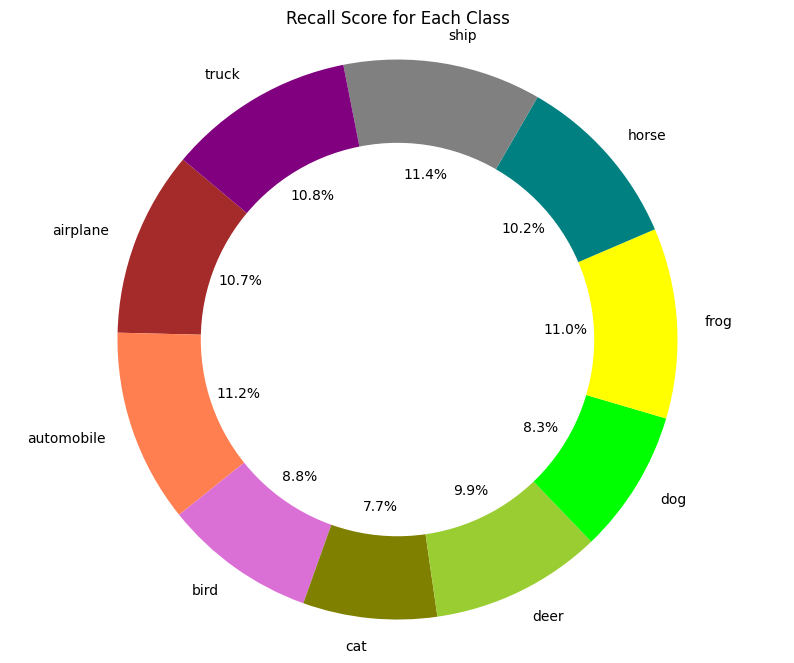

In [35]:
colors = ['brown', 'coral', 'orchid', 'olive', 'yellowgreen', 'lime', 'yellow', 'teal', 'grey', 'purple']

plt.figure(figsize=(10, 8))
ax = plt.gca()

wedges, texts, autotexts = ax.pie(df['Recall'], labels=df['Class'], autopct='%1.1f%%', startangle=140, colors=colors)

circle = Circle((0, 0), 0.7, color='white')
ax.add_artist(circle)

ax.axis('equal')
plt.title('Recall Score for Each Class')
plt.show()

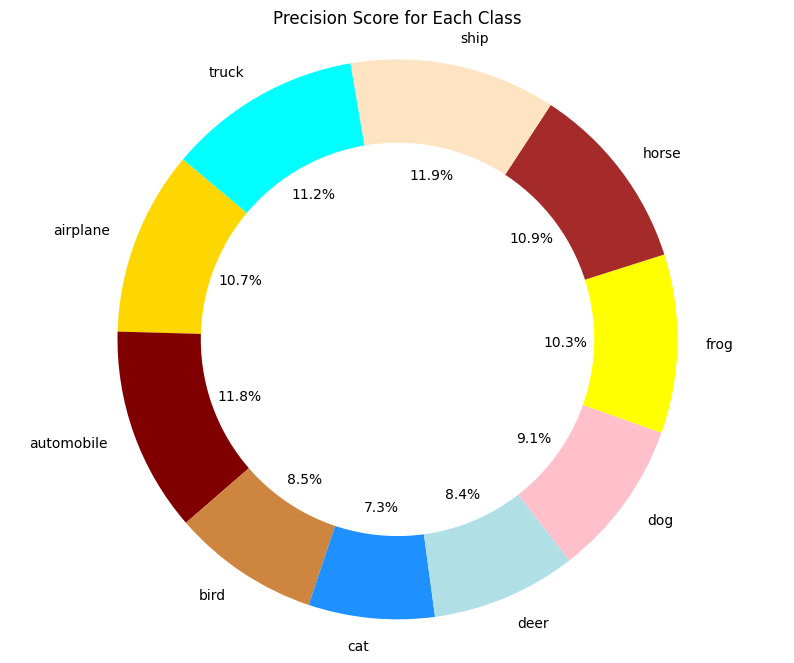

In [36]:
colors = ['gold', 'maroon', 'peru', 'dodgerblue', 'powderblue', 'pink', 'yellow', 'brown', 'bisque', 'aqua']

plt.figure(figsize=(10, 8))
ax = plt.gca()

wedges, texts, autotexts = ax.pie(df['Precision'], labels=df['Class'], autopct='%1.1f%%', startangle=140, colors=colors)

circle = Circle((0, 0), 0.7, color='white')
ax.add_artist(circle)

ax.axis('equal')
plt.title('Precision Score for Each Class')
plt.show()

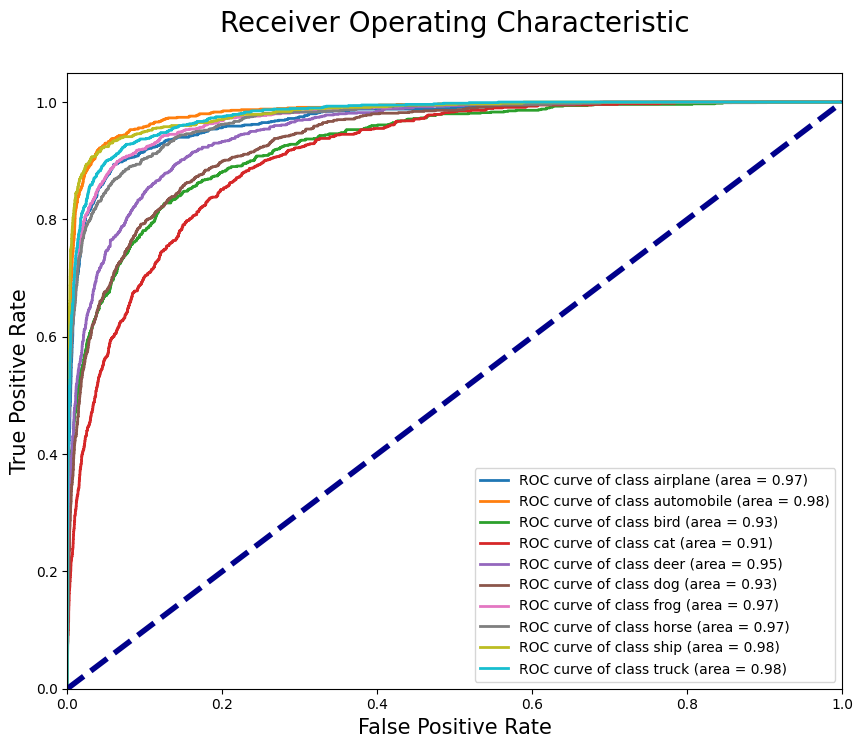

In [37]:
import matplotlib as mpl
import matplotlib.cm as cm

fpr = dict()
tpr = dict()
roc_auc = dict()
num_classes = len(label_name)

for class_index in range(num_classes):
    fpr[class_index], tpr[class_index], _ = roc_curve((y_test_labels == class_index).astype(int), pred[:, class_index])
    roc_auc[class_index] = auc(fpr[class_index], tpr[class_index])

# Plot the ROC curves
plt.figure(figsize=(10, 8))
colors = cm.tab20(np.arange(num_classes) / num_classes)

for class_index in range(num_classes):
    plt.plot(fpr[class_index], tpr[class_index], color=colors[class_index], lw=2, label='ROC curve of class {} (area = {:0.2f})'.format(label_name[class_index], roc_auc[class_index]))

plt.plot([0, 1], [0, 1], linestyle="--", lw=4, color="darkblue")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=15, color="black")
plt.ylabel('True Positive Rate', fontsize=15, color="black")
plt.title('Receiver Operating Characteristic\n', fontsize=20, color="black")
plt.legend(loc="lower right")
plt.show()

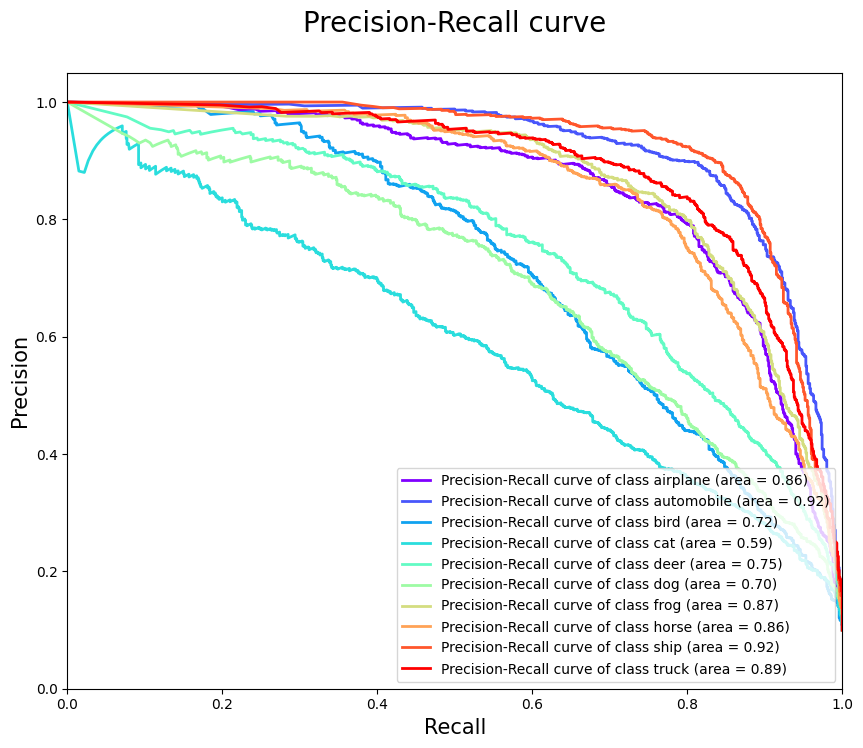

In [38]:


num_classes = len(label_name)
precision = dict()
recall = dict()
average_precision = dict()
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_labels == i, pred[:, i])
    average_precision[i] = average_precision_score(y_test_labels == i, pred[:, i])

plt.figure(figsize=(10, 8))
colors = cycle(cm.rainbow(np.linspace(0, 1, num_classes)))
for i, color in zip(range(num_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='Precision-Recall curve of class {0} (area = {1:0.2f})'.format(label_name[i], average_precision[i]))



plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=15, color="black")
plt.ylabel('Precision', fontsize=15, color="black")
plt.title('Precision-Recall curve\n', fontsize=20, color="black")
plt.legend(loc="lower right")
plt.show()

# Prediction

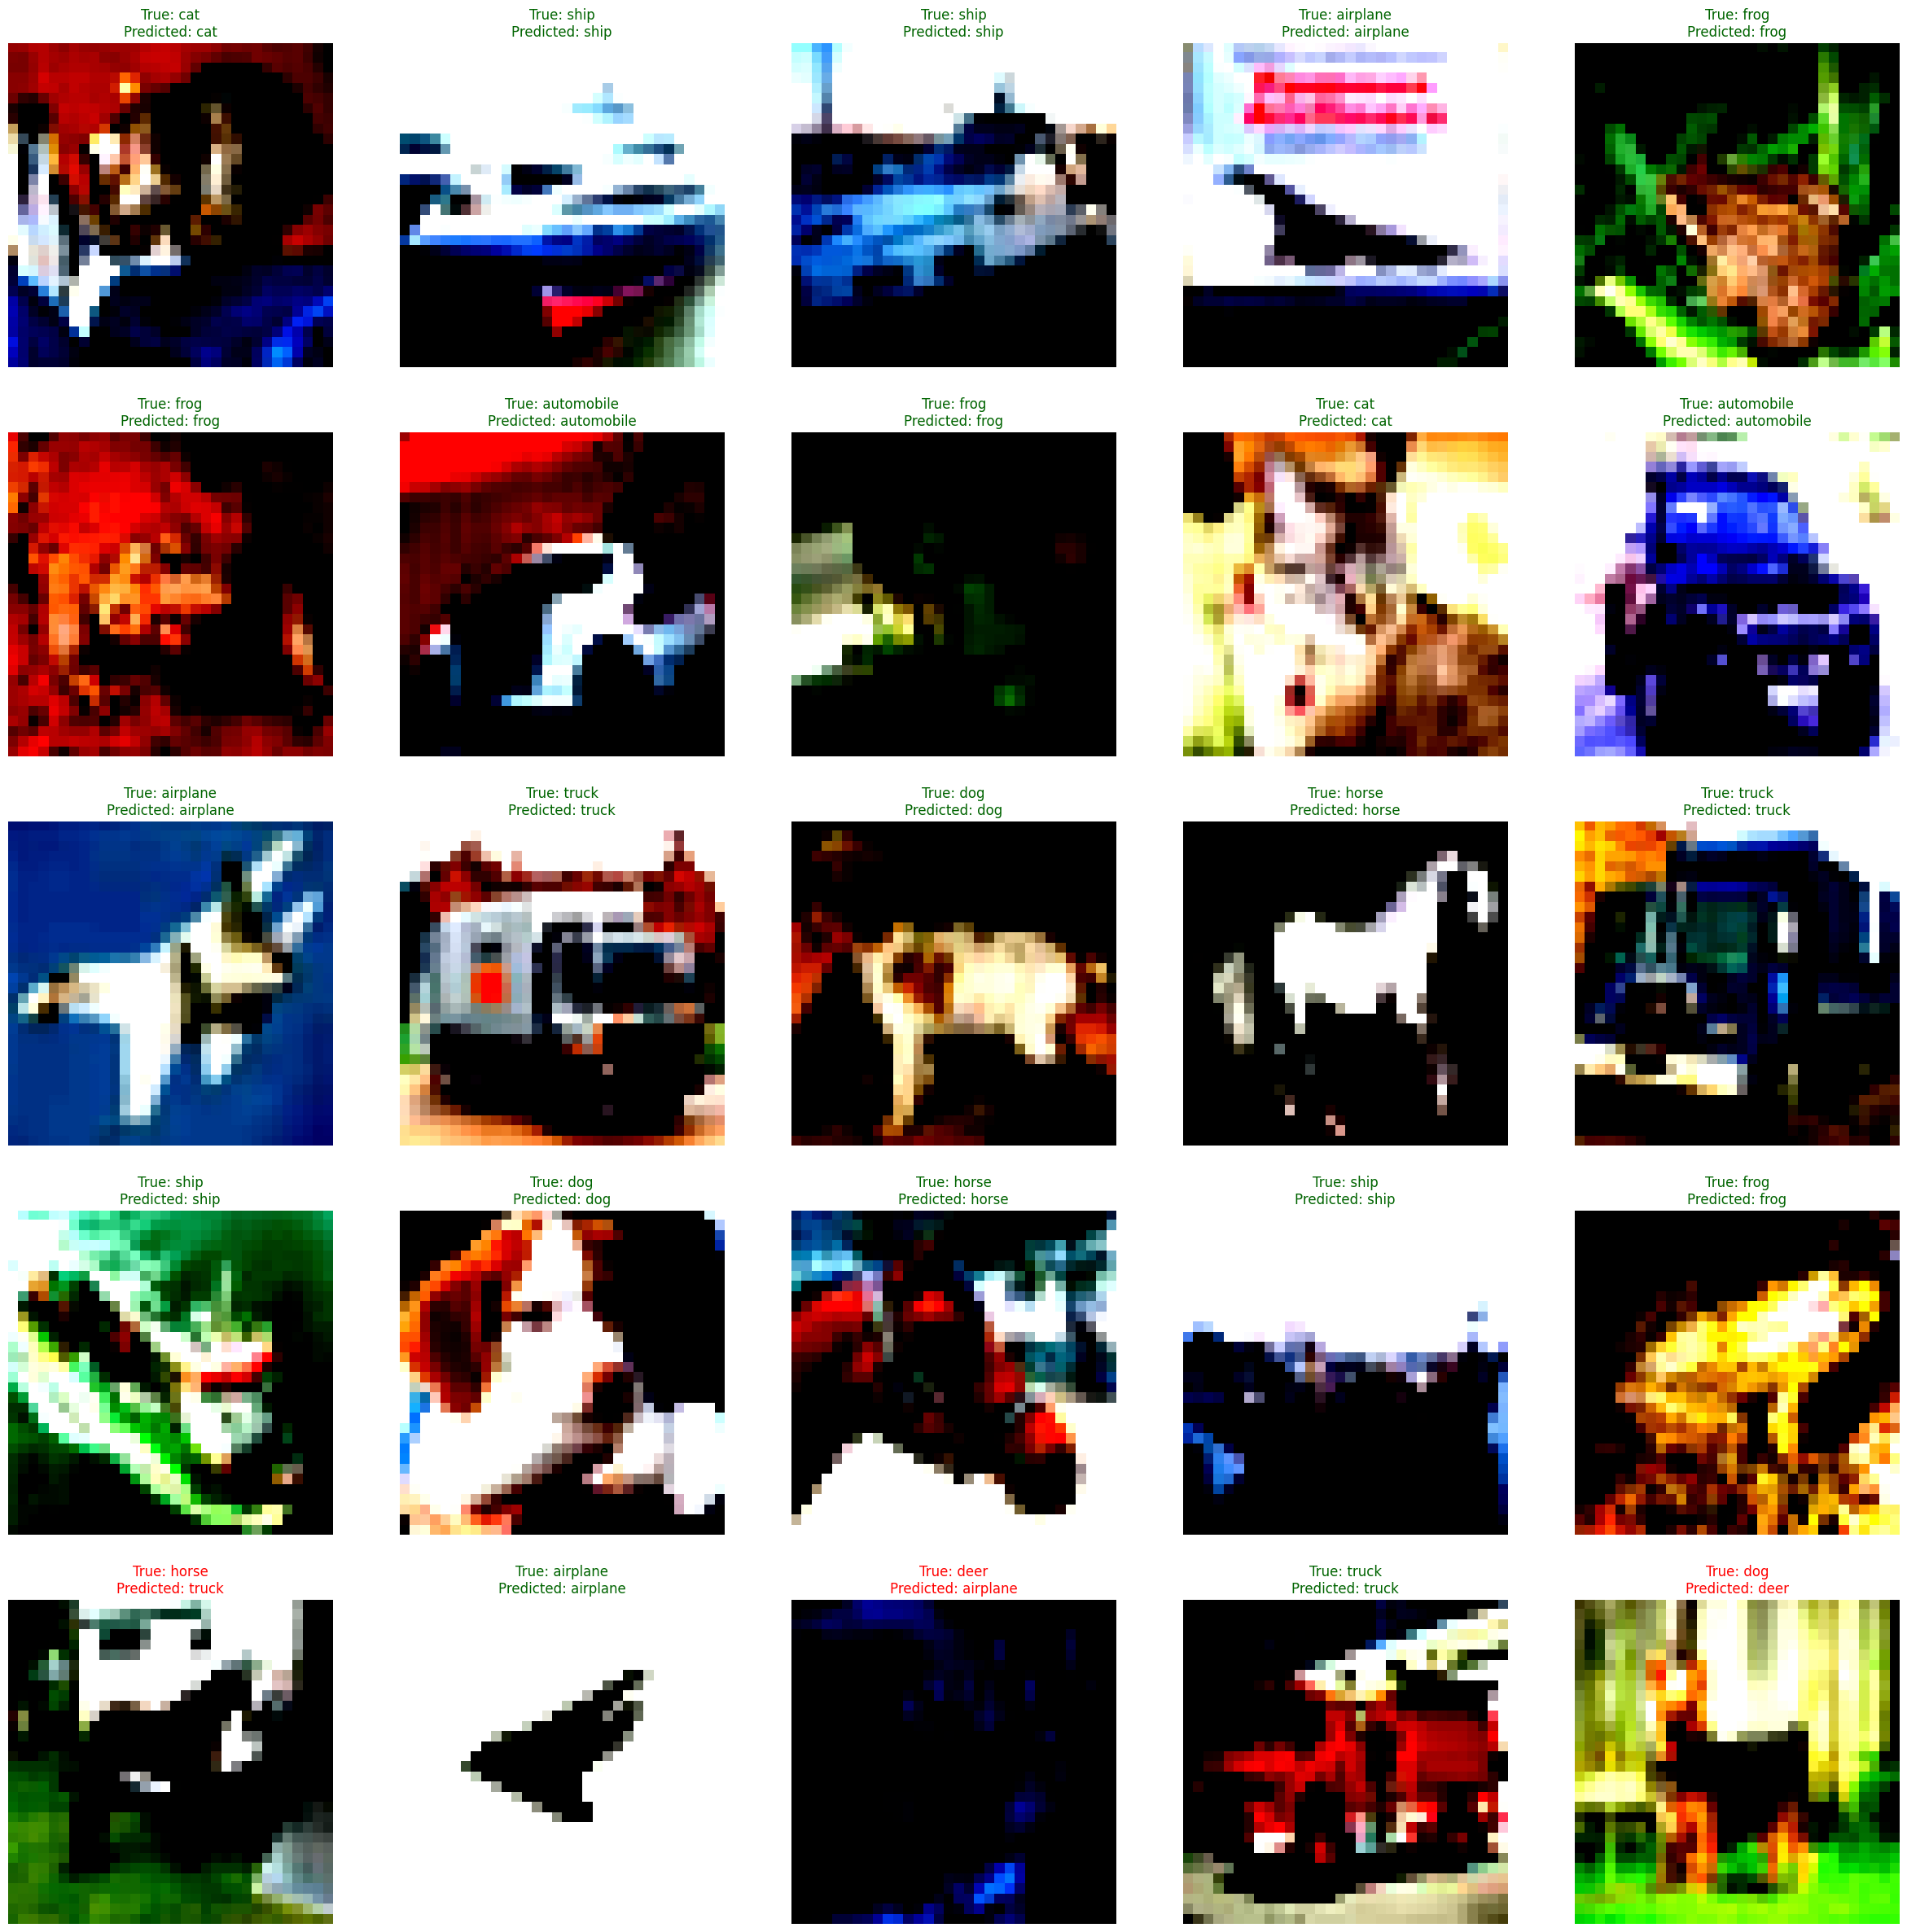

In [39]:

plt.figure(figsize=(30, 30))
number_images = (5, 5)
num_samples = min(number_images[0] * number_images[1], len(x_test))

for i in range(num_samples):
    plt.subplot(number_images[0], number_images[1], i + 1)
    plt.axis("off")
    
    true_label = label_name[y_test_labels[i]]
    predicted_label = label_name[final_pred[i]]
    
    color = "darkgreen"
    if true_label != predicted_label:
        color = "red"
    
    plt.title(f"True: {true_label}\nPredicted: {predicted_label}", color=color)
    plt.imshow(x_test[i])  # Assuming x_test[i] is already an image array
plt.show()


# Custom Data Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 826ms/step
Predicted class: ship
Maximum probability: 1.0


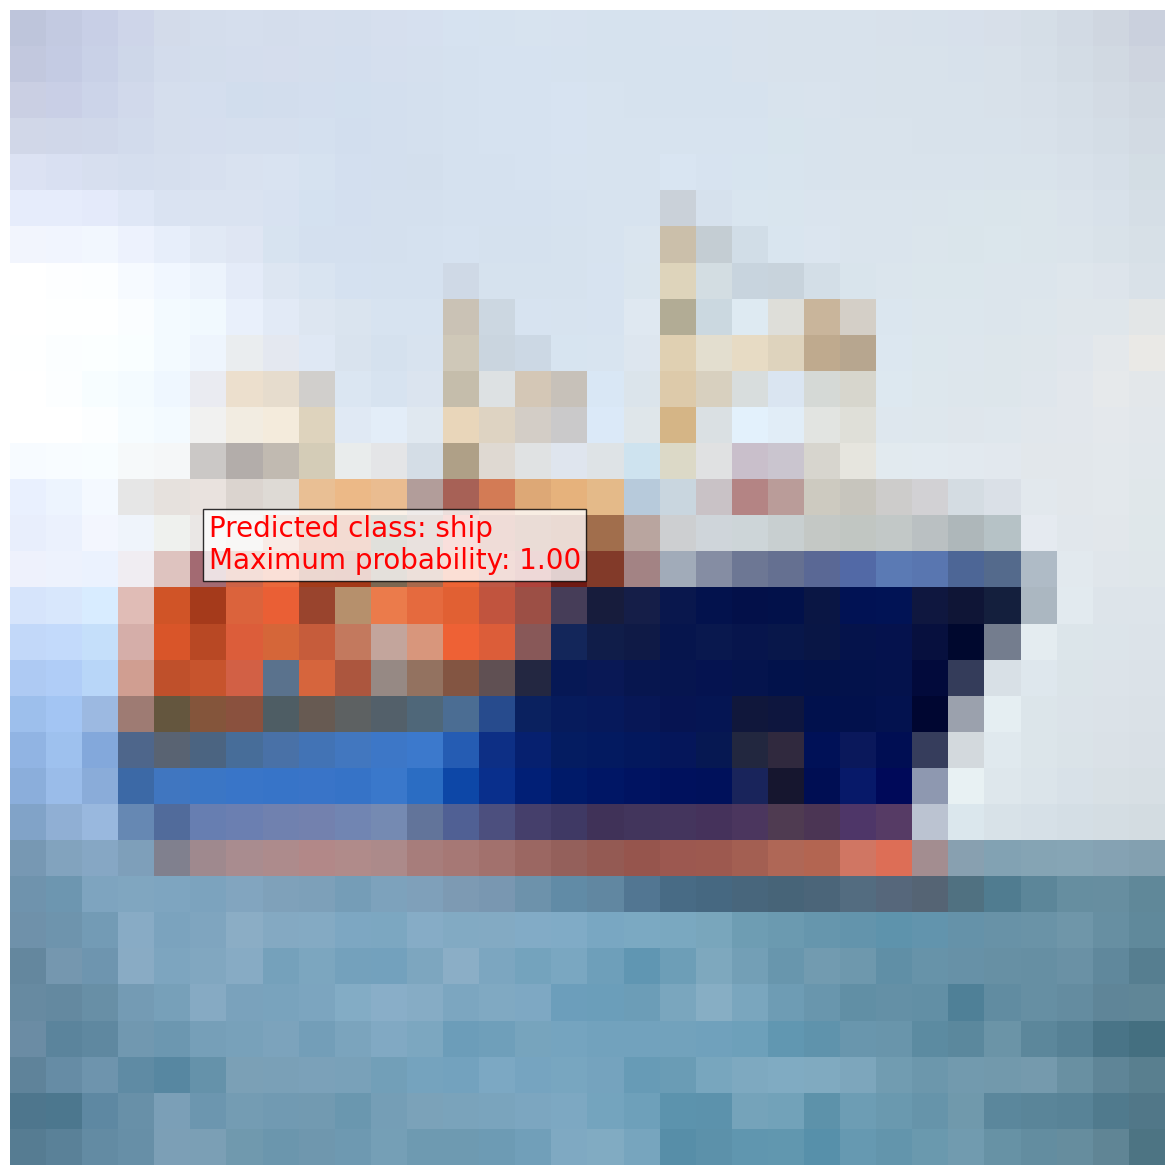

In [40]:
plt.figure(figsize=(15, 15))
import urllib.request
import os
from PIL import Image
img_url = "https://t3.ftcdn.net/jpg/00/41/06/42/360_F_41064239_IaGdGyf1vxHFaNDS5K164OFOwiMe1hC9.jpg"

# Retrieve the image from the URL
filename, headers = urllib.request.urlretrieve(img_url)
img_path = os.path.join(os.getcwd(), filename)
img = Image.open(img_path)
img = img.resize((32,32))
img = np.array(img) / 255.0
img = np.expand_dims(img, axis=0)

# Predict the class of the image using the model
probs = model.predict(img)[0]

# Get the predicted class index and name
pred_class_prob = np.argmax(probs)
pred_class_name = label_name[pred_class_prob]

max_prob = np.max(probs)
print(f'Predicted class: {pred_class_name}')
print(f'Maximum probability: {max_prob}')

# Display the image with the predicted class and probability
plt.imshow(img[0])
plt.axis('off')
plt.text(5, 15, f'Predicted class: {pred_class_name}\nMaximum probability: {max_prob:.2f}', fontsize=20, color='red', bbox=dict(facecolor='white', alpha=0.8))
plt.show()